This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Analysis for PBMC2 10x

In [52]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

import os
import collections

res_name = "pbmc10x_rep2"
exp_str = "pbmc2"
method_str = "10x Chromium (v2)"

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# we are working with PBMCs so lets store some marker genes
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

marker_genes_dict = {
    'CD14 Mono': ['CD14', 'LYZ'],
    'CD16 Mono': ['FCGR3A', 'MS4A7'],
    'Dendritic': ['FCER1A', 'CST3'],
    'NK': ['GNLY', 'NKG7', 'KLRB1'],
    'B Cell': ['CD79A', 'MS4A1'],
    #'Plasma': ['IGJ'],
    'CD4 T': ['IL7R'],
    'CD8 T': ['CD8A', 'CD8B'],
    'Megakaryocytes': ['PPBP']
}

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


## Open files

In [53]:
data_path = f"{os.getcwd()}/../../data/single_cell_data/GSE132044/10x_hg19/"

results_file = f"{data_path}/{res_name}.h5ad"

adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


... reading from cache file cache/beevol-home-davidson-checkouts-sc_bulk_ood-evaluation_experiments-pbmc-..-..-data-single_cell_data-GSE132044-10x_hg19-matrix.h5ad


In [54]:
# make cell type specific marker annotation

genes_annot_dict = {
    'CD14': ['CD14 (CD14 Mono)'],
    'LYZ': ['LYZ (CD14 Mono)'],
    'FCGR3A': ['FCGR3A (CD16 Mono)'],
    'MS4A7': ['MS4A7 (CD16 Mono)'],
    'FCER1A': ['FCER1A (Dendritic)'],
    'CST3': ['CST3 (Dendritic)'],
    'GNLY': ['GNLY (NK)'],
    'NKG7': ['NKG7 (NK)'],
    'MS4A1': ['MS4A1 (B)'],
    'IL7R': ['IL7R (CD4T)'],
    'CCR7': ['CCR7 (Naive CD4T)'],
    'S100A4': ['S100A4 (Memory CD4T)'],
    'CD8A': ['CD8A (CD8 T)'],
    'PPBP': ['PPBP (Megak)']
}

# Initialize empty column in cell metadata
adata.var['gene_annot'] = adata.var_names

# Generate new assignments
for i in genes_annot_dict.keys():
    ind = np.where(pd.Series(adata.var_names).isin([i]))[0]
    adata.var['gene_annot'].iloc[ind] = genes_annot_dict[i]
adata.var['gene_annot'].iloc[ind]

PPBP    PPBP (Megak)
Name: gene_annot, dtype: object

In [55]:
# add metadata
meta_cols = ['code', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method']
barcodes = pd.read_csv(f"{data_path}/barcodes.tsv", header=None, names=['code'])
meta_data = pd.read_csv(f"{data_path}/GSE132044_meta.txt", skiprows=2, names=meta_cols, index_col='code', sep="\t")
meta_df = barcodes.join(other=meta_data, on=['code'], how='left', sort=False)

adata.obs['CellType'] = meta_df['CellType'].tolist()
adata.obs['Experiment'] = meta_df['Experiment'].tolist()
adata.obs['Method'] = meta_df['Method'].tolist()
meta_df

code   nGene     nUMI  \
0                          pbmc1_Celseq2_1_ACAGAC  3290.0   9030.0   
1                          pbmc1_Celseq2_1_ACAGGA  2797.0   8482.0   
2                          pbmc1_Celseq2_1_ACGTTG  2651.0   6787.0   
3                          pbmc1_Celseq2_1_AGACCA  2766.0   6004.0   
4                          pbmc1_Celseq2_1_CAACTC  3510.0  10162.0   
...                                           ...     ...      ...   
44428  pbmc2_inDrops_1_TAGTCTCT.GAGCCTTA.ATCCGCTA   453.0    717.0   
44429  pbmc2_inDrops_1_TCCAGAAG.TTATGCGA.TAAGACGG   592.0    938.0   
44430  pbmc2_inDrops_1_TGAATCCT.GAGCCTTA.CCCAAGCA   406.0    662.0   
44431  pbmc2_inDrops_1_TGAATCCT.TTATGCGA.CATCTCCC  1001.0   2066.0   
44432  pbmc2_inDrops_1_TGAGCACA.GAGCCTTA.CGAGTCTG   184.0    253.0   

       percent.mito  Cluster                     CellType Experiment    Method  
0          0.090255      1.0                  CD4+ T cell      pbmc1  CEL-Seq2  
1          0.116954      1.0                  CD4+ T cell      pbmc1  CEL-Seq2  
2          0.111979      1.0                  CD4+ T cell      pbmc1  CEL-Seq2  
3          0.093271      1.0                  CD4+ T cell      pbmc1  CEL-Seq2  
4          0.116217      1.0                  CD4+ T cell      pbmc1  CEL-Seq2  
...             ...      ...                          ...        ...       ...  
44428      0.097629     11.0  Plasmacytoid dendritic cell      pbmc2   inDrops  
44429      0.035181     11.0  Plasmacytoid dendritic cell      pbmc2   inDrops  
44430      0.138973     11.0  Plasmacytoid dendritic cell      pbmc2   inDrops  
44431      0.055663     11.0  Plasmacytoid dendritic cell      pbmc2   inDrops  
44432      0.146245     11.0  Plasmacytoid dendritic cell      pbmc2   inDrops  

[44433 rows x 8 columns]

## Preprocessing

In [56]:
# lets see whats in adata
adata

AnnData object with n_obs × n_vars = 44433 × 33694
    obs: 'CellType', 'Experiment', 'Method'
    var: 'gene_ids', 'gene_annot'

In [57]:
# filter it for only our method and experiment
adata = adata[adata.obs["Experiment"] == exp_str, :]
adata = adata[adata.obs["Method"] == method_str, :]

adata

View of AnnData object with n_obs × n_vars = 3362 × 33694
    obs: 'CellType', 'Experiment', 'Method'
    var: 'gene_ids', 'gene_annot'

normalizing counts per cell
    finished (0:00:00)


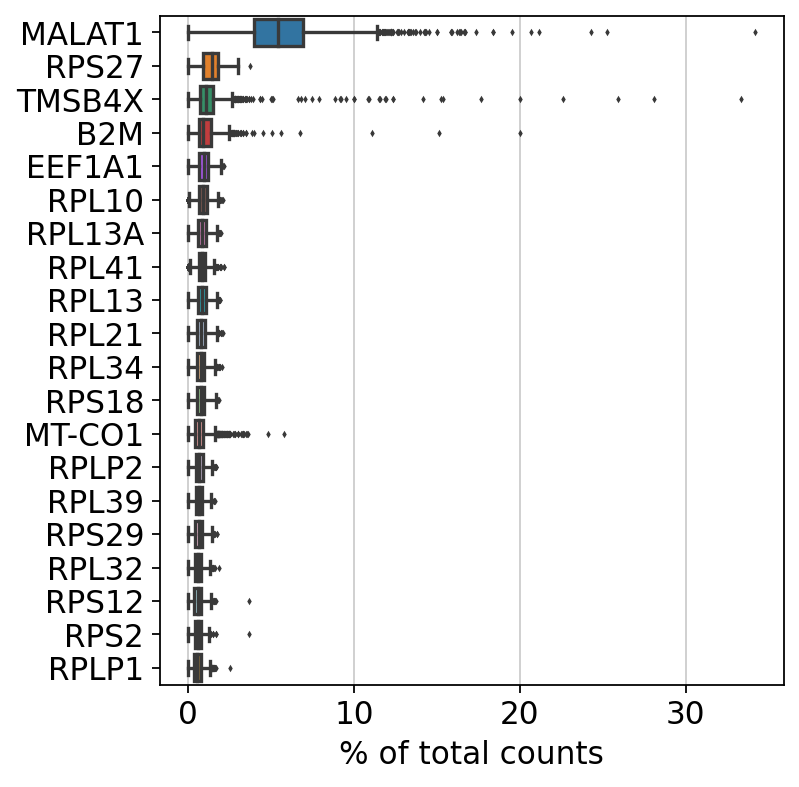

In [58]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [59]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)


filtered out 149 cells that have less than 500 genes expressed
filtered out 16839 genes that are detected in less than 5 cells


... storing 'CellType' as categorical
... storing 'Experiment' as categorical
... storing 'Method' as categorical


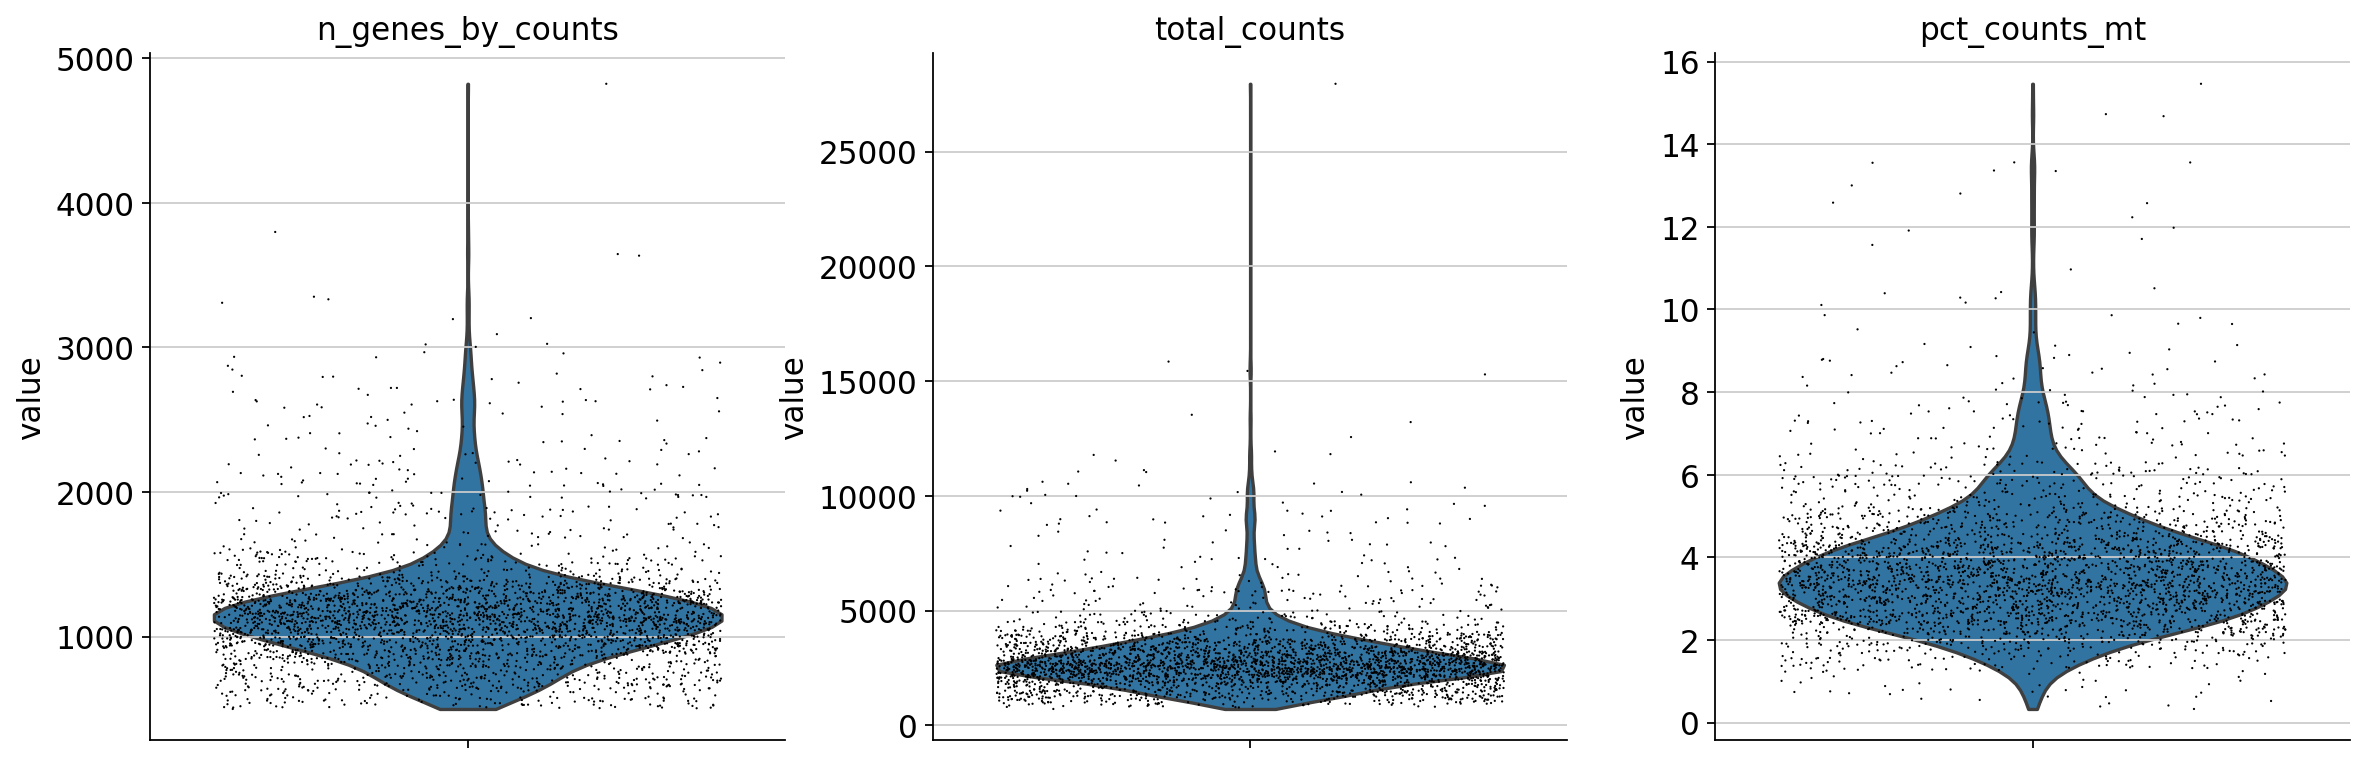

In [60]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

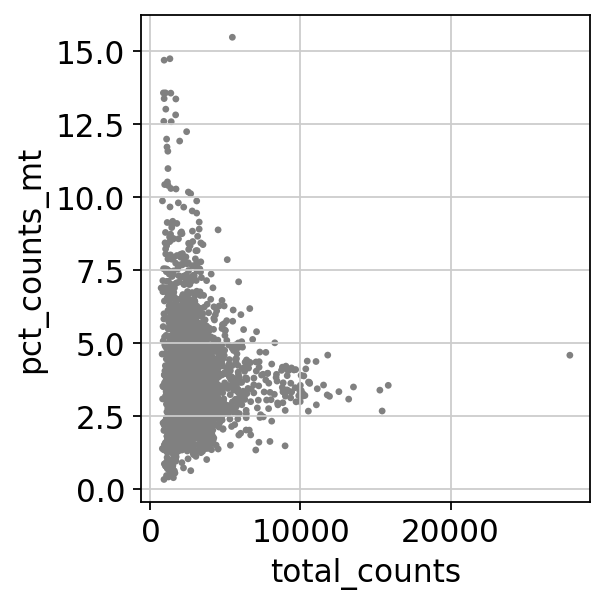

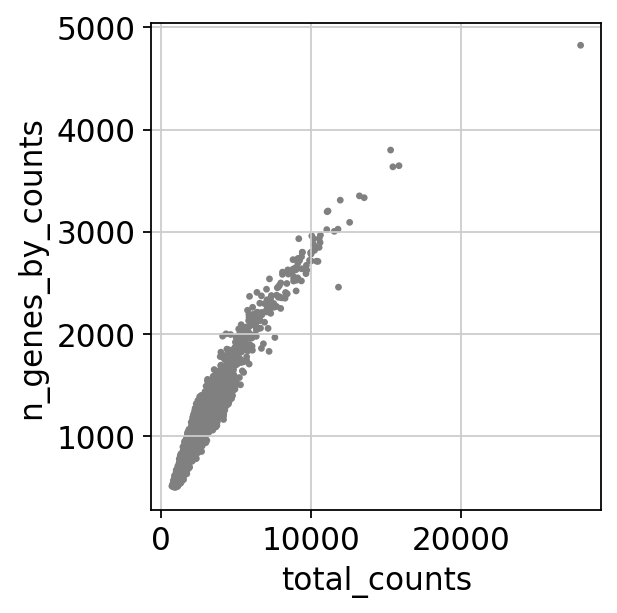

In [61]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [62]:
# slice the data based on the plots from above
# remove cells with more than 2500 genes
# remove cells with more than 5% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 7, :]

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


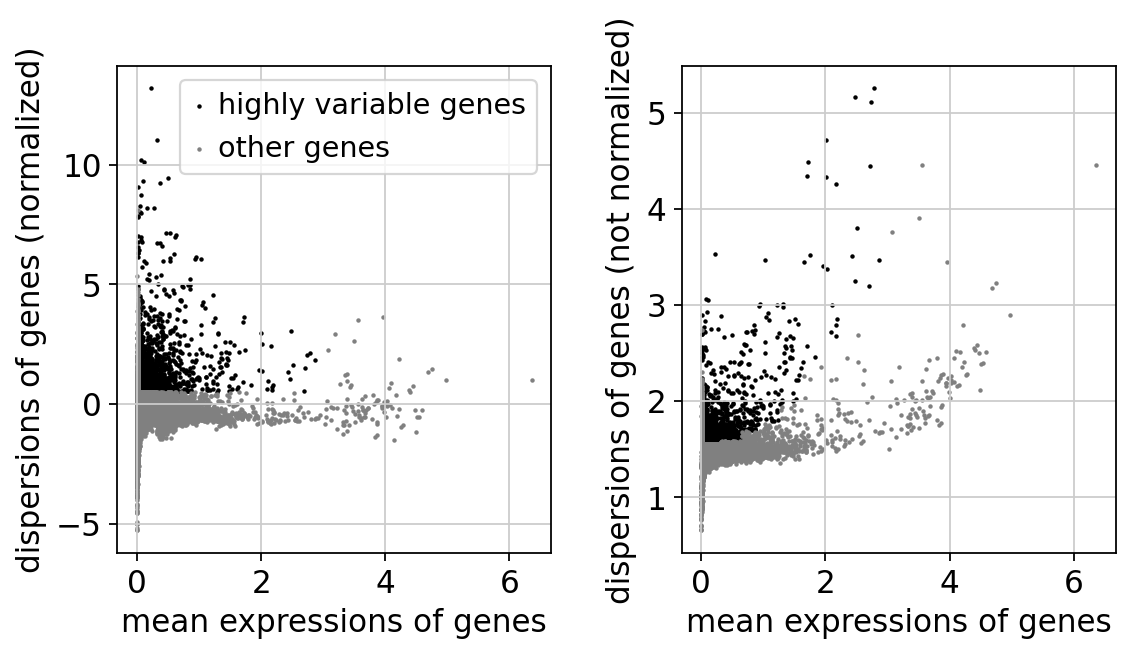

In [63]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
adata.raw = adata
adata.write(results_file)


In [64]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:19)


## PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


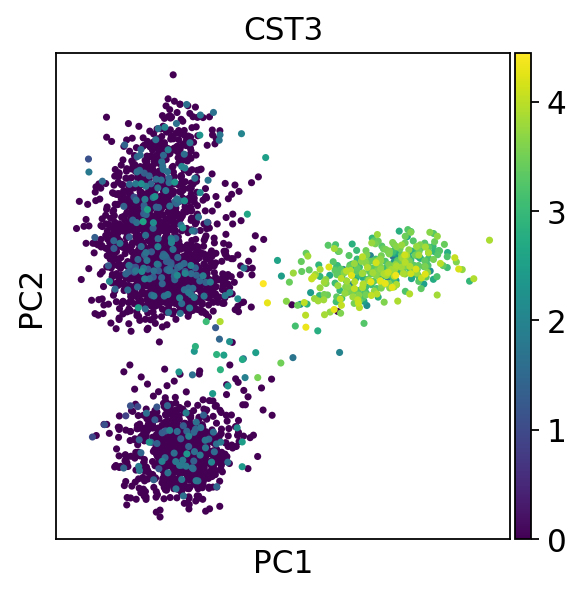

In [65]:
sc.tl.pca(adata, n_comps=50)
sc.pl.pca(adata, color='CST3')


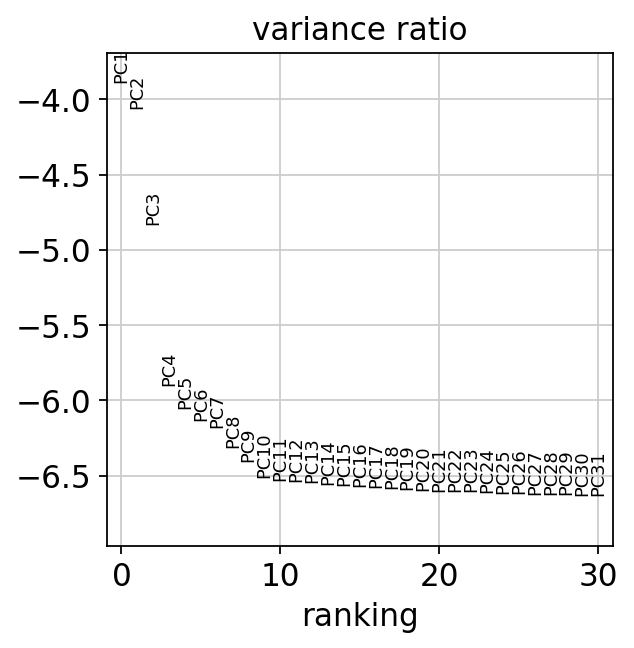

In [66]:
sc.pl.pca_variance_ratio(adata, log=True)


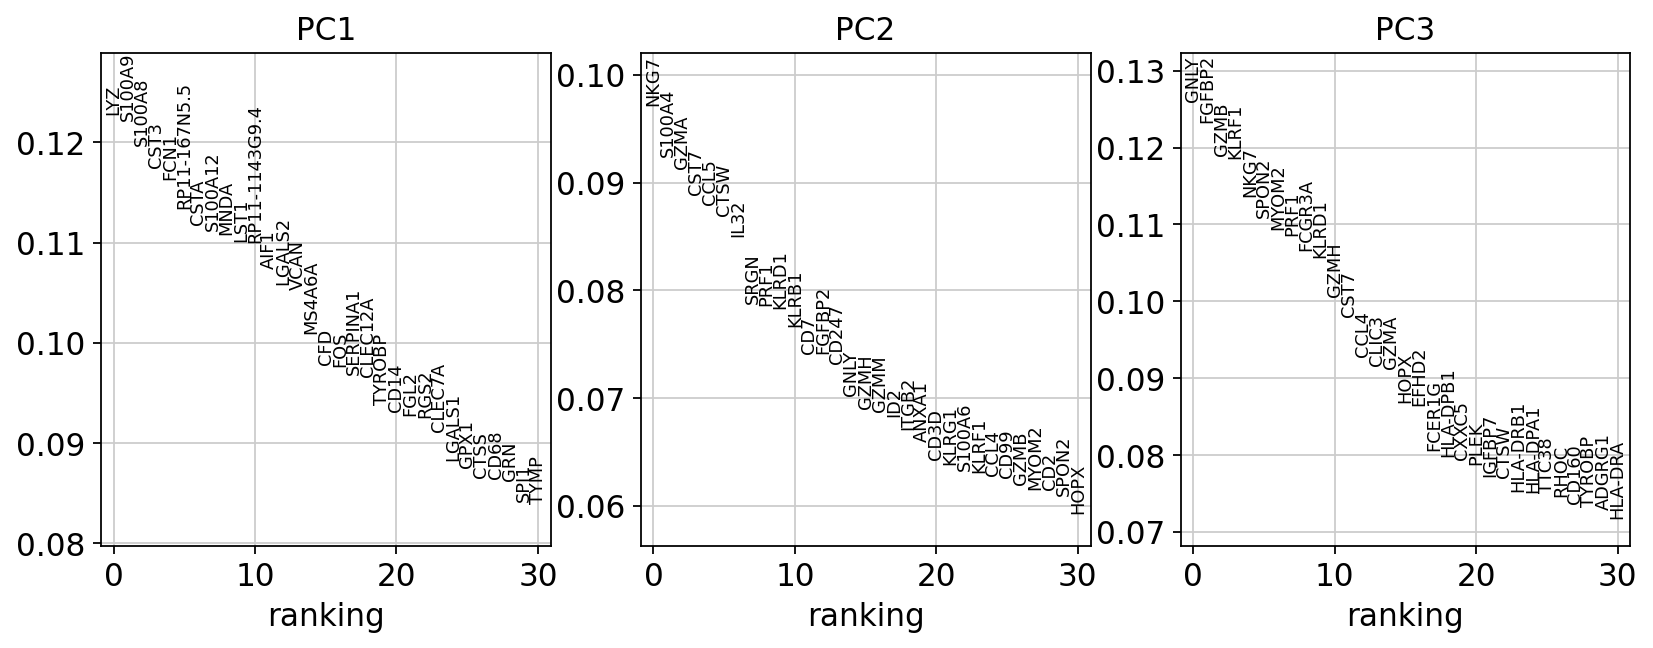

In [67]:
sc.pl.pca_loadings(adata, include_lowest=False)


In [68]:
# save results
adata.write(results_file)


## Compute and embed neighborhood graph

In [69]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


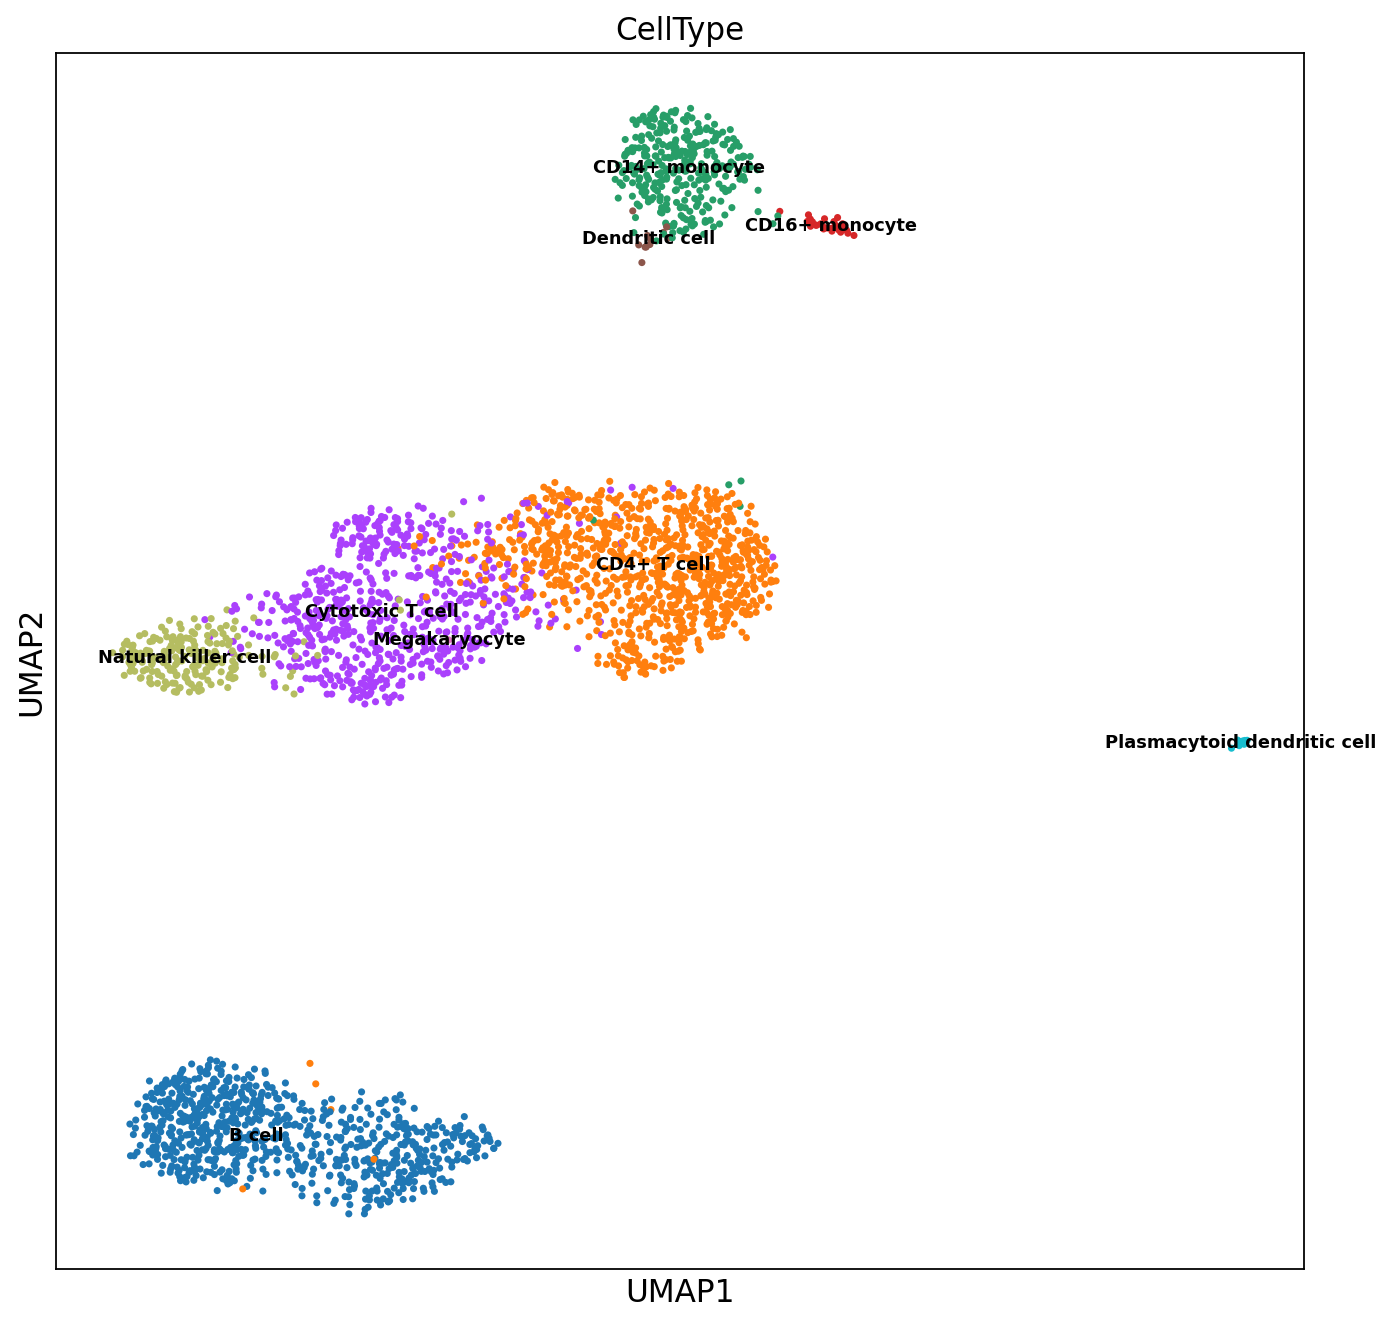

In [70]:
# plot some markers of the RAW data
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, legend_loc='on data', color='CellType', legend_fontsize=8)

## Cluster the neighborhood graph

running Leiden clustering
    finished (0:00:00)


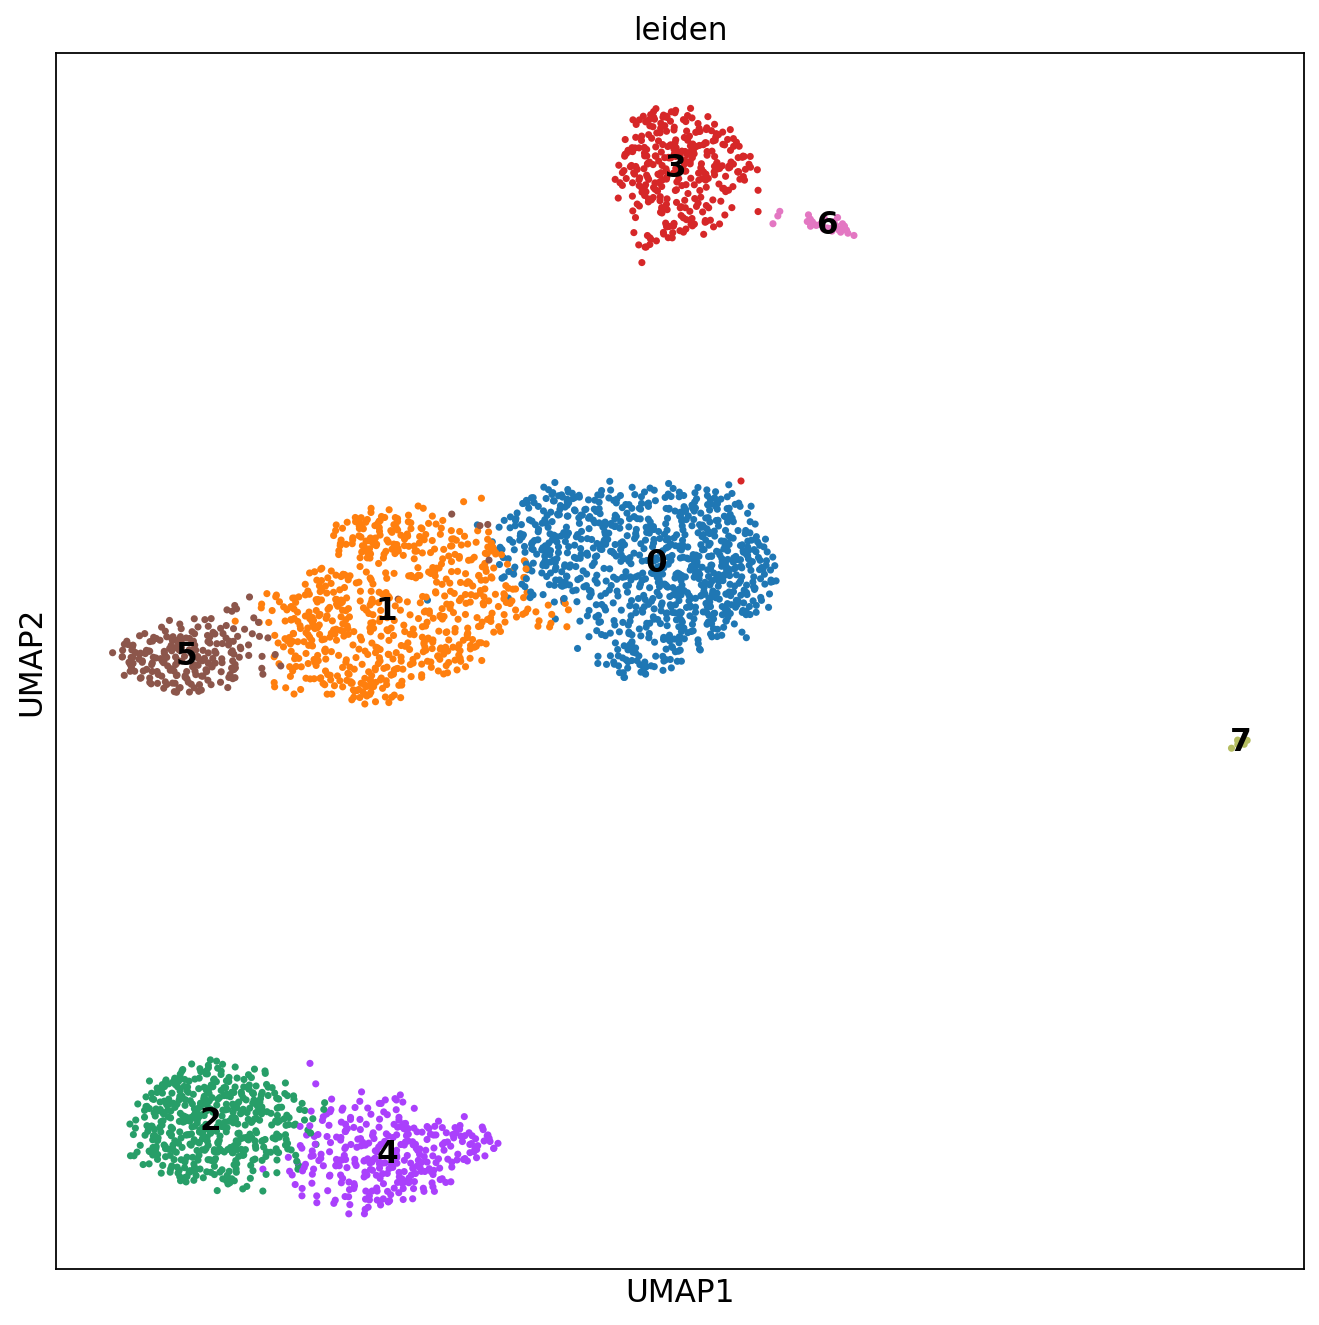

In [89]:
# lets use Leiden clustering
sc.tl.leiden(adata, resolution=0.8)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='leiden', legend_loc='on data')

# save
adata.write(results_file)


# merge cell type labels

In [94]:
# make merged cell type predictions
cell_dict = {'CD4+ T cell': ['0'], 'B cell': ['2', '4'], 'Cytotoxic T cell': ['1'], 'CD14+ monocyte': ['3'],
    'Natural killer cell': ['5'], 'CD16+ monocyte': ['6']}


# Initialize empty column in cell metadata
adata.obs['merged'] = np.nan

# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'merged'] = i




In [95]:
# write out how many of each cell type are found in both and each
celltype_consistent = adata.obs['merged'][adata.obs['merged'] == adata.obs['CellType']]
frequency = collections.Counter(celltype_consistent)
print("Freq. of Cell type  consistent between publication and clustering")
print(dict(frequency))

frequency = collections.Counter(adata.obs['CellType'])
print("Freq. of Cell type in publication")
print(dict(frequency))

frequency = collections.Counter(adata.obs['merged'])
print("Freq. of Cell type in clustering")
print(dict(frequency))

Freq. of Cell type  consistent between publication and clustering
{'B cell': 794, 'Cytotoxic T cell': 604, 'CD4+ T cell': 862, 'Natural killer cell': 196, 'CD14+ monocyte': 307, 'CD16+ monocyte': 29}
Freq. of Cell type in publication
{'B cell': 795, 'Cytotoxic T cell': 657, 'Dendritic cell': 12, 'CD4+ T cell': 912, 'Natural killer cell': 208, 'CD14+ monocyte': 312, 'Megakaryocyte': 1, 'CD16+ monocyte': 29, 'Plasmacytoid dendritic cell': 12}
Freq. of Cell type in clustering
{'B cell': 799, 'Cytotoxic T cell': 662, 'CD14+ monocyte': 319, 'CD4+ T cell': 897, 'Natural killer cell': 217, 'CD16+ monocyte': 31, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1}


... storing 'merged' as categorical


categories: B cell, CD4+ T cell, CD14+ monocyte, etc.
var_group_labels: CD14 Mono, CD16 Mono, Dendritic, etc.


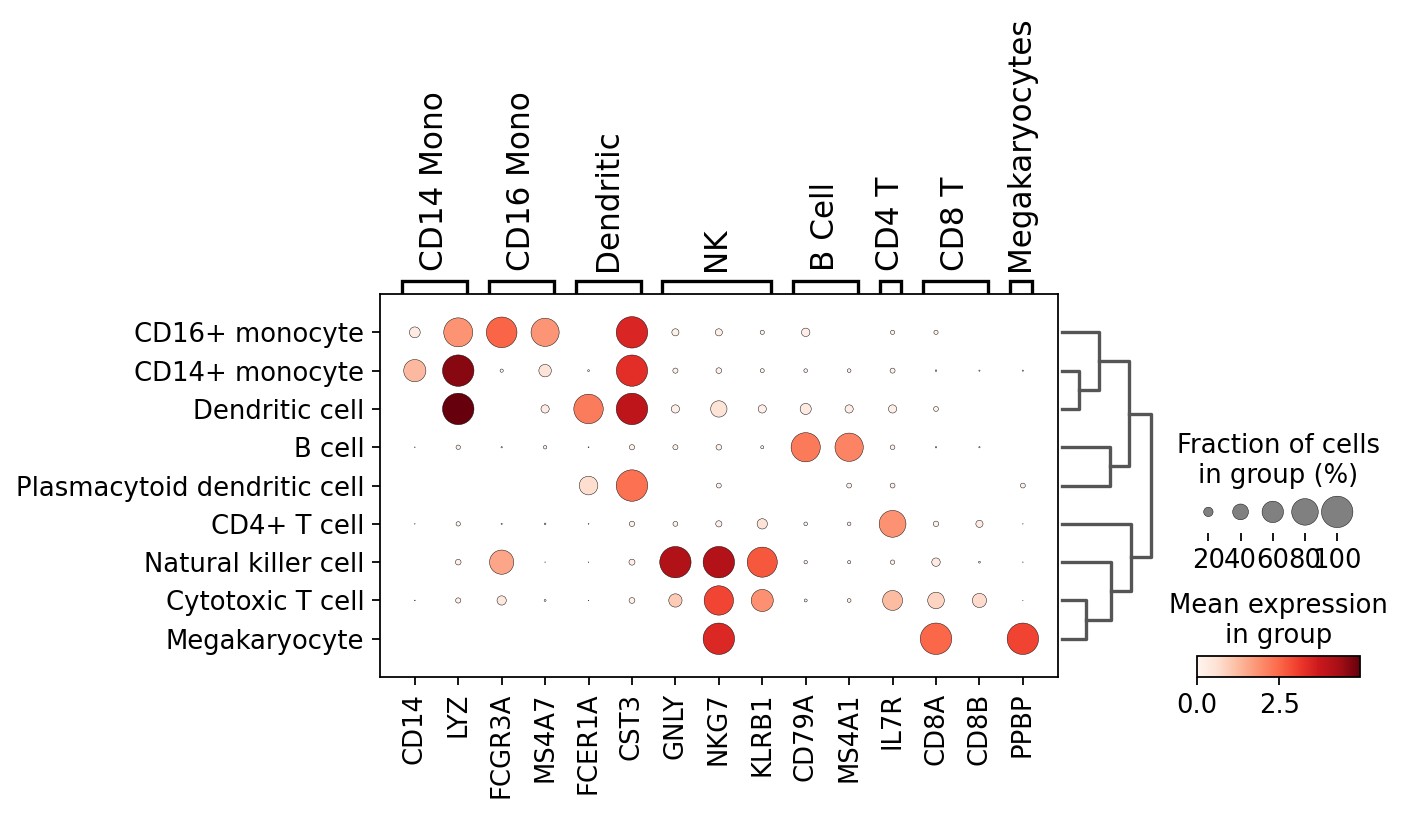

In [96]:
# now as a dotplot show it for all samples
sc.pl.dotplot(adata, marker_genes_dict, groupby='CellType', dendrogram=True)


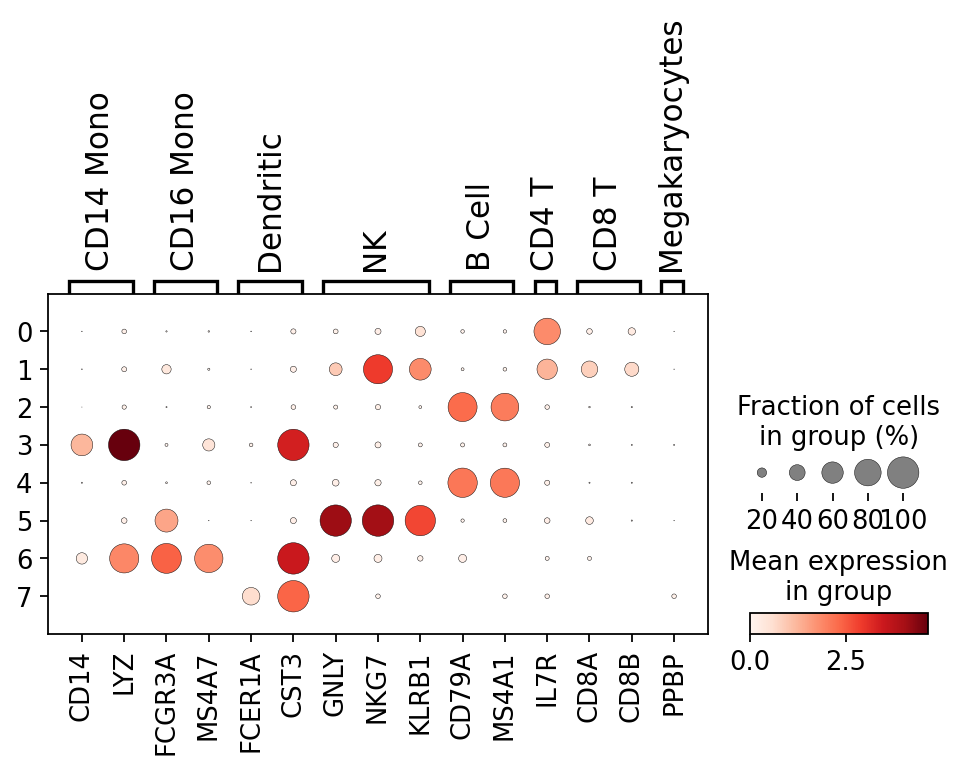

In [97]:
# now as a dotplot show it for all samples
sc.pl.dotplot(adata, marker_genes_dict, groupby='leiden', dendrogram=False)


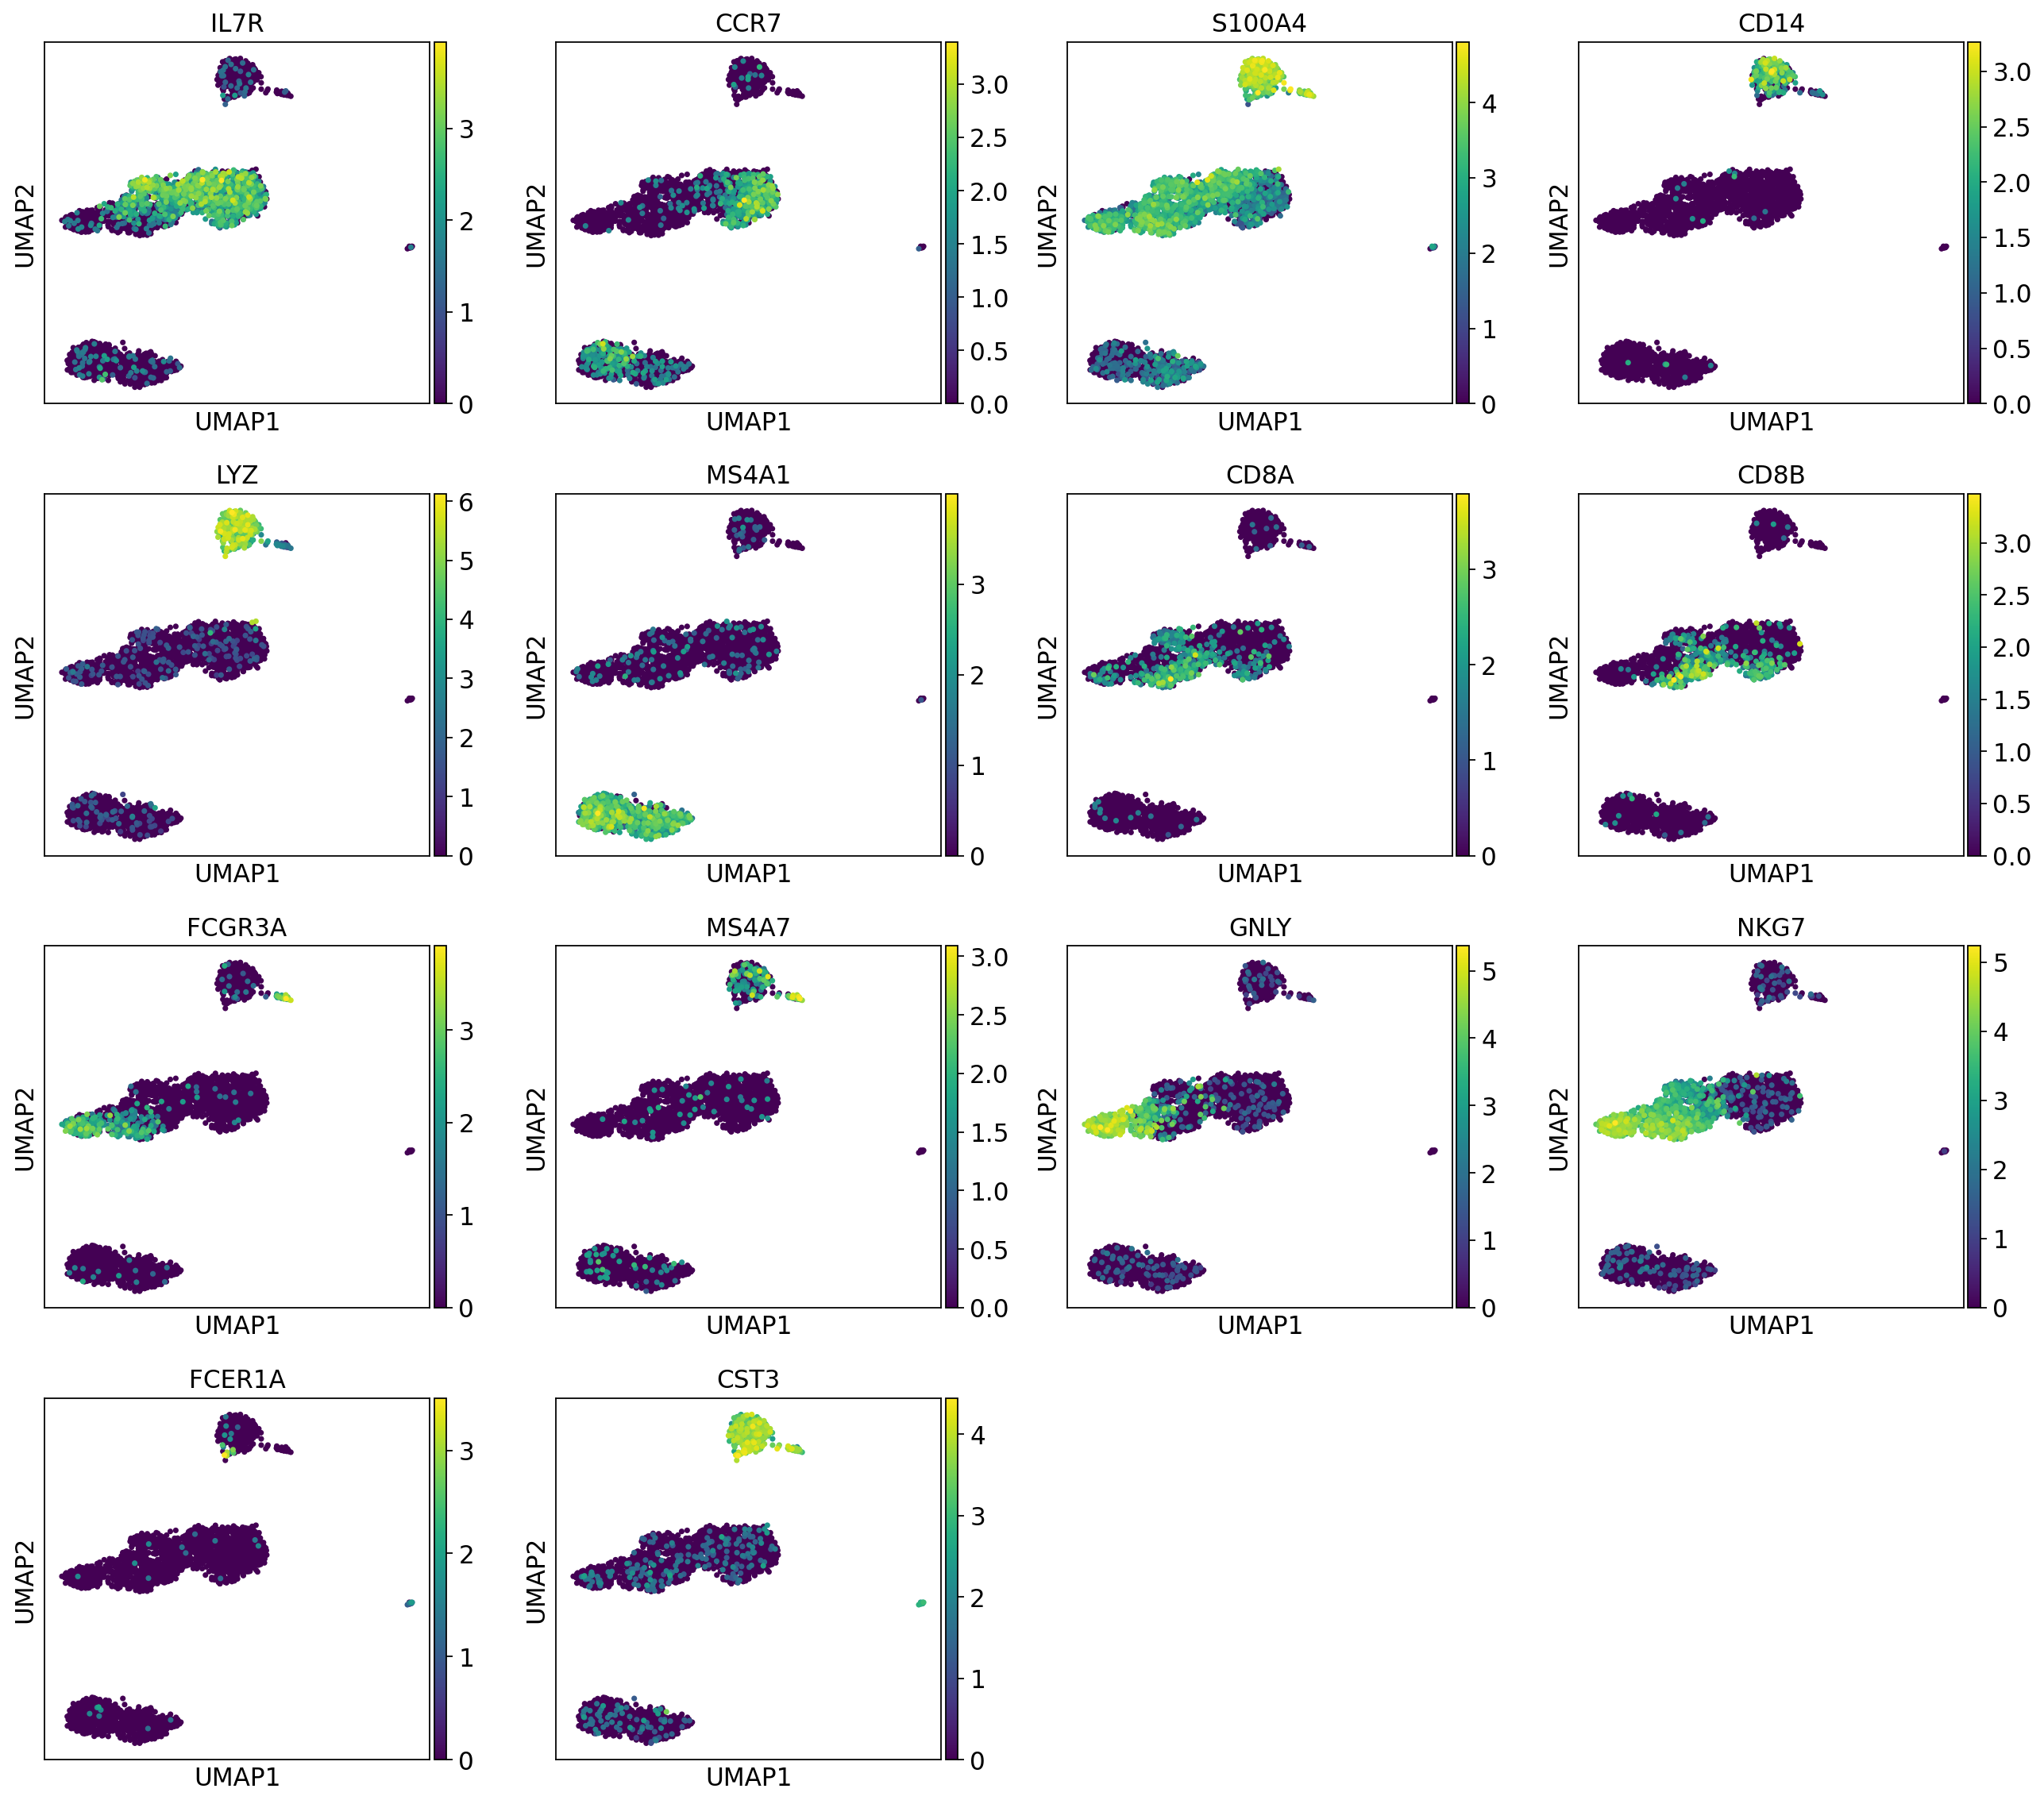

In [98]:
gene_list = ['IL7R', 'CCR7', 'S100A4', 'CD14', 'LYZ', 'MS4A1', 'CD8A', 'CD8B',
    'FCGR3A', 'MS4A7', 'GNLY', 'NKG7', 'FCER1A', 'CST3']

sc.pl.umap(adata, color=[i for i in gene_list], color_map='viridis', legend_fontsize=8)

## Find marker genes

ranking genes
    finished (0:00:00)


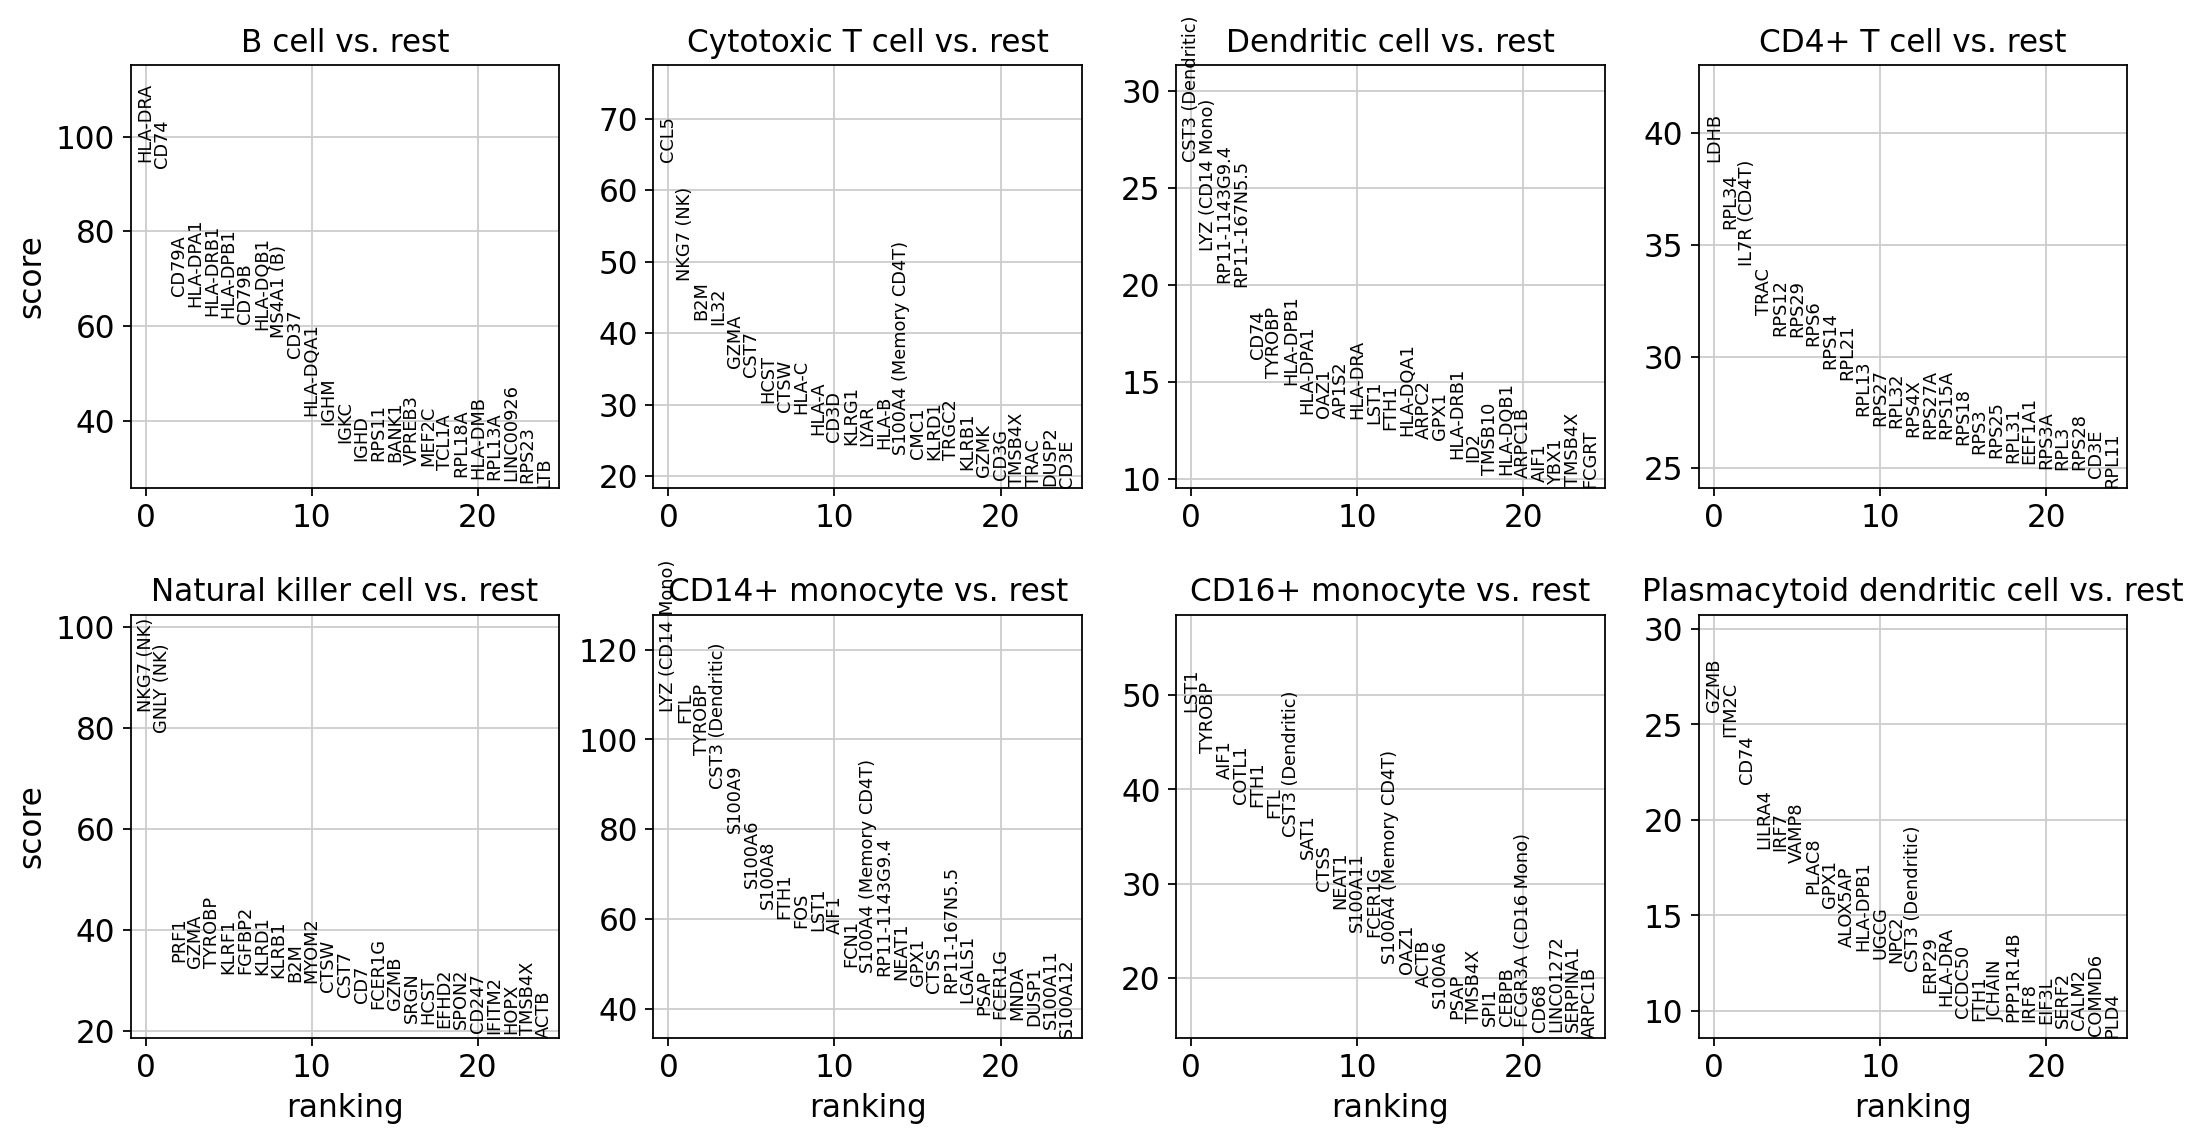

In [107]:
sc.settings.verbosity = 2  # reduce the verbosity
groups_comp = ['B cell', 'Cytotoxic T cell', 'Dendritic cell', 'CD4+ T cell', 
                'Natural killer cell', 'CD14+ monocyte', 'CD16+ monocyte', 'Plasmacytoid dendritic cell']

sc.tl.rank_genes_groups(adata, 'CellType', method='t-test', groups=groups_comp) # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)

ranking genes
    finished (0:00:04)


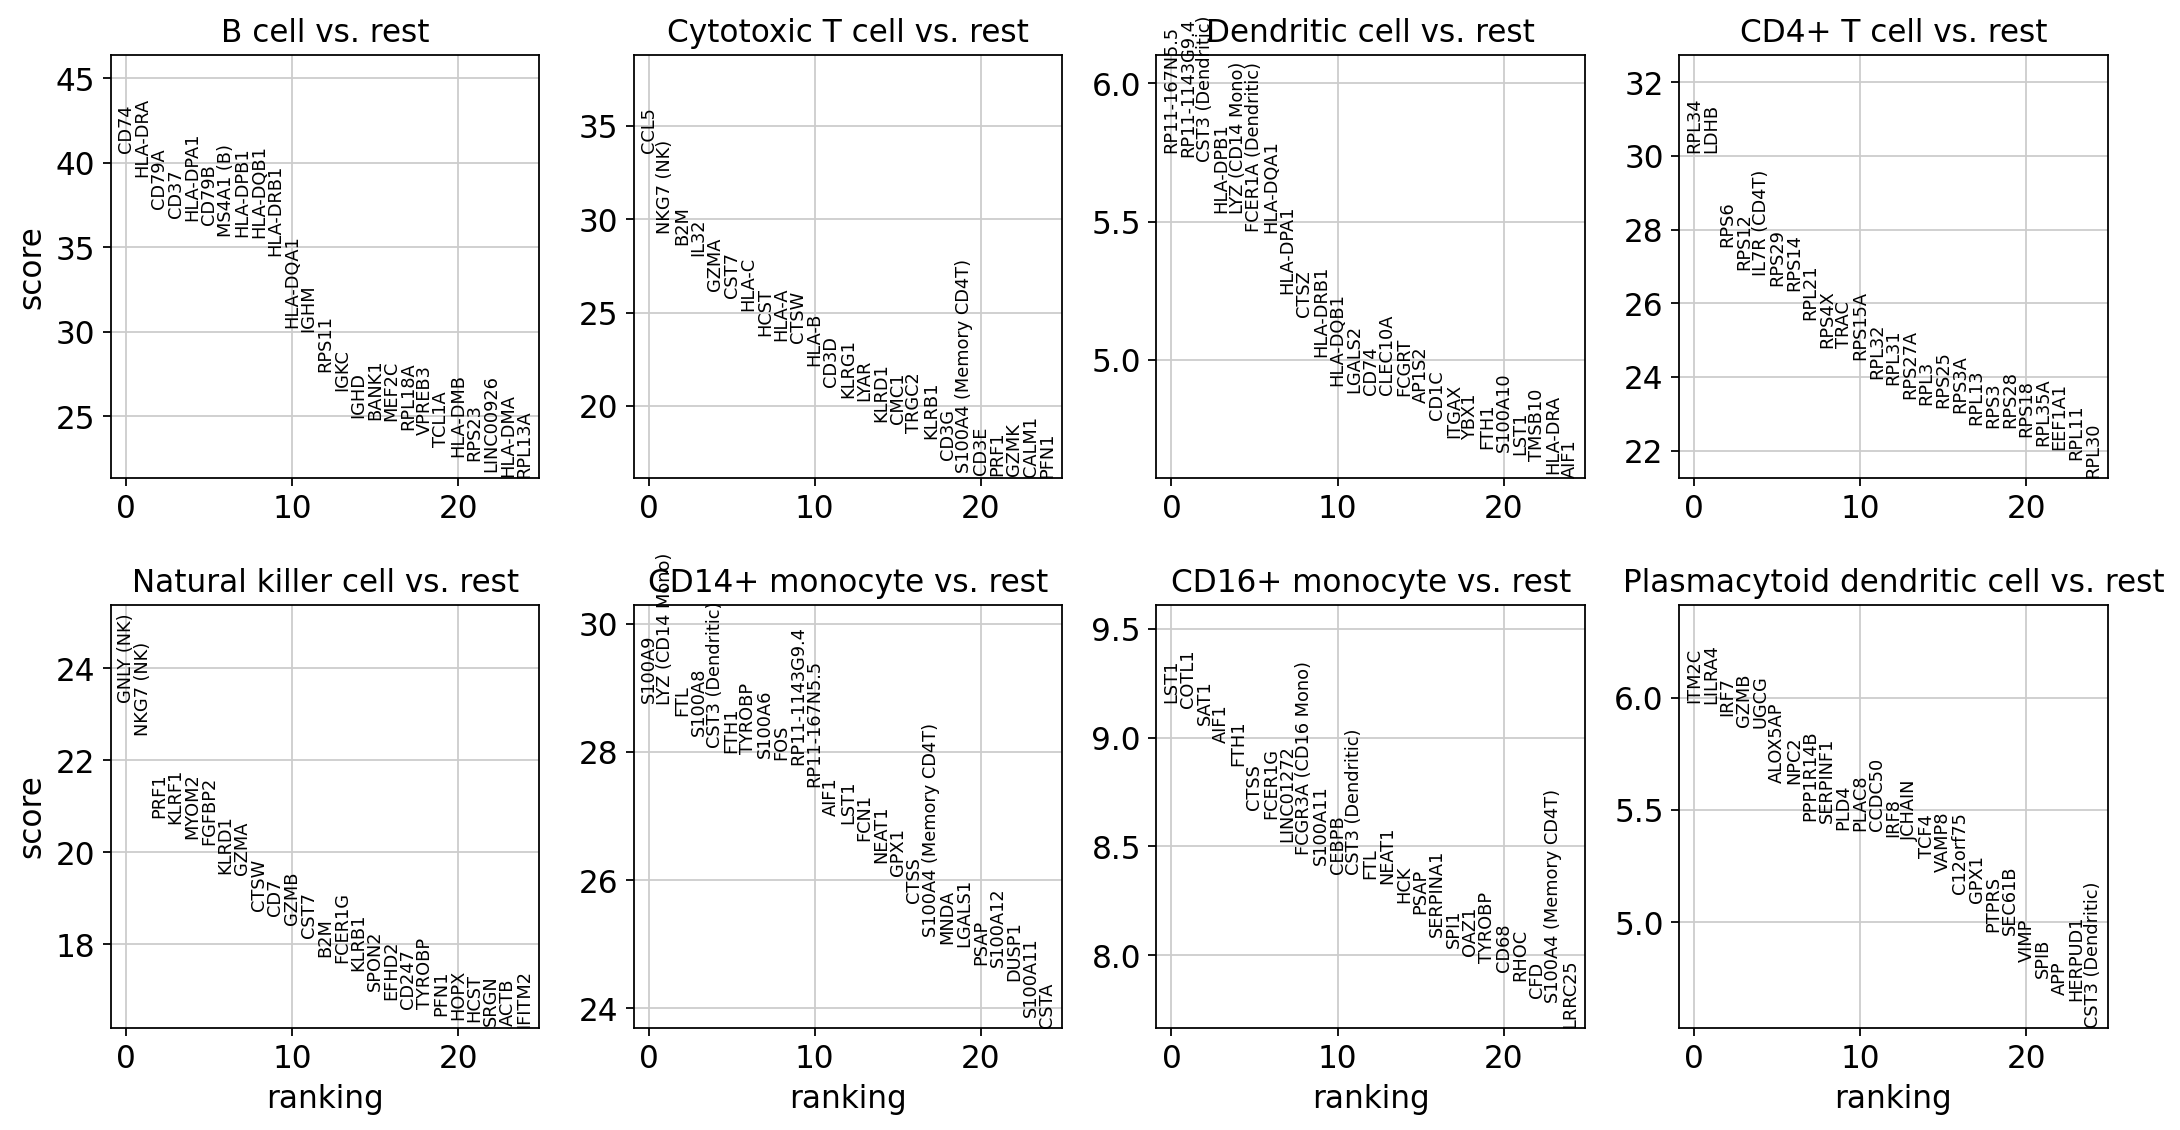

In [99]:

sc.tl.rank_genes_groups(adata, 'CellType', method='wilcoxon', groups=groups_comp) # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)

ranking genes
    finished (0:00:05)


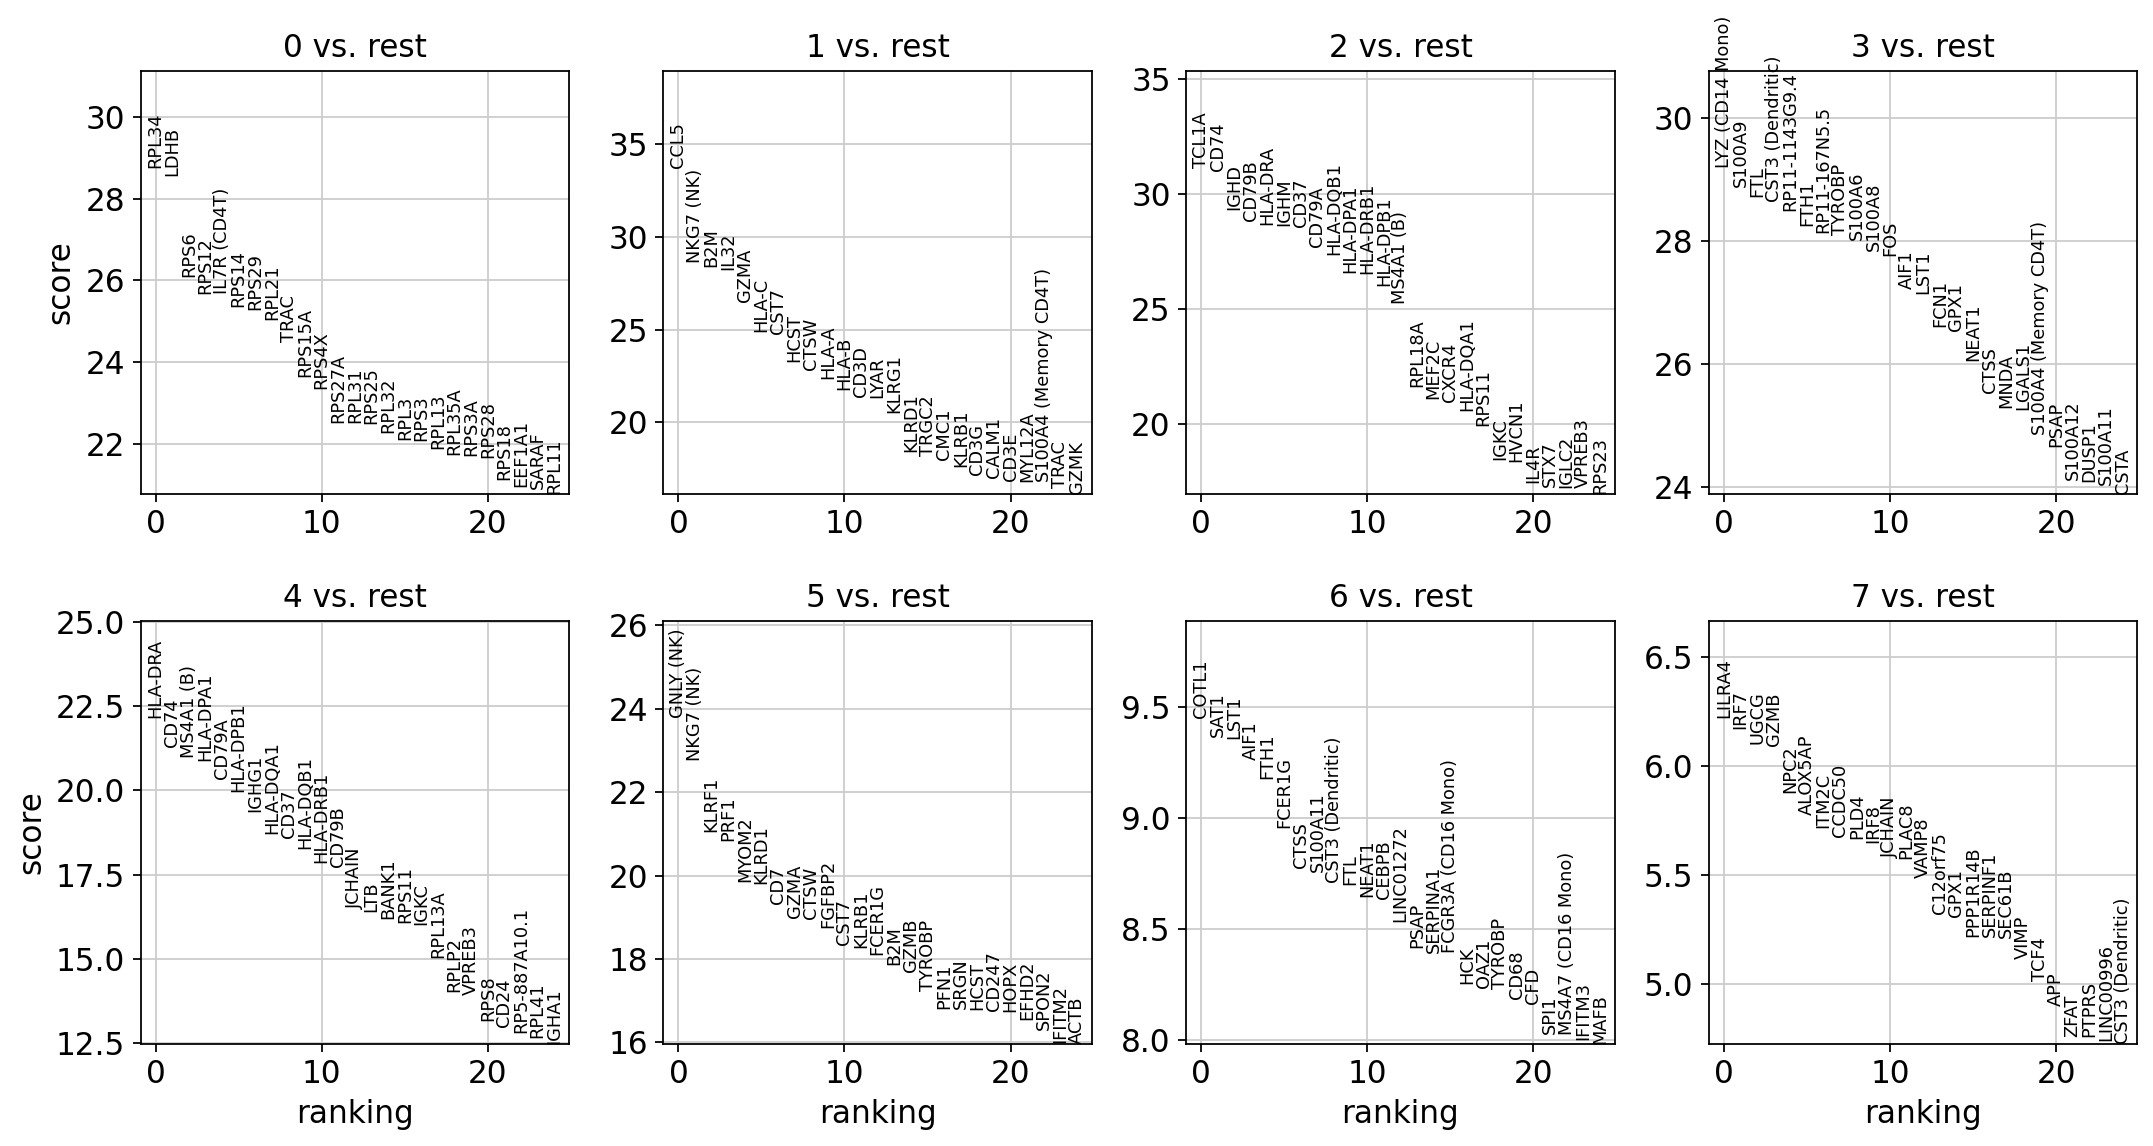

In [100]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)


ranking genes
    finished (0:00:04)


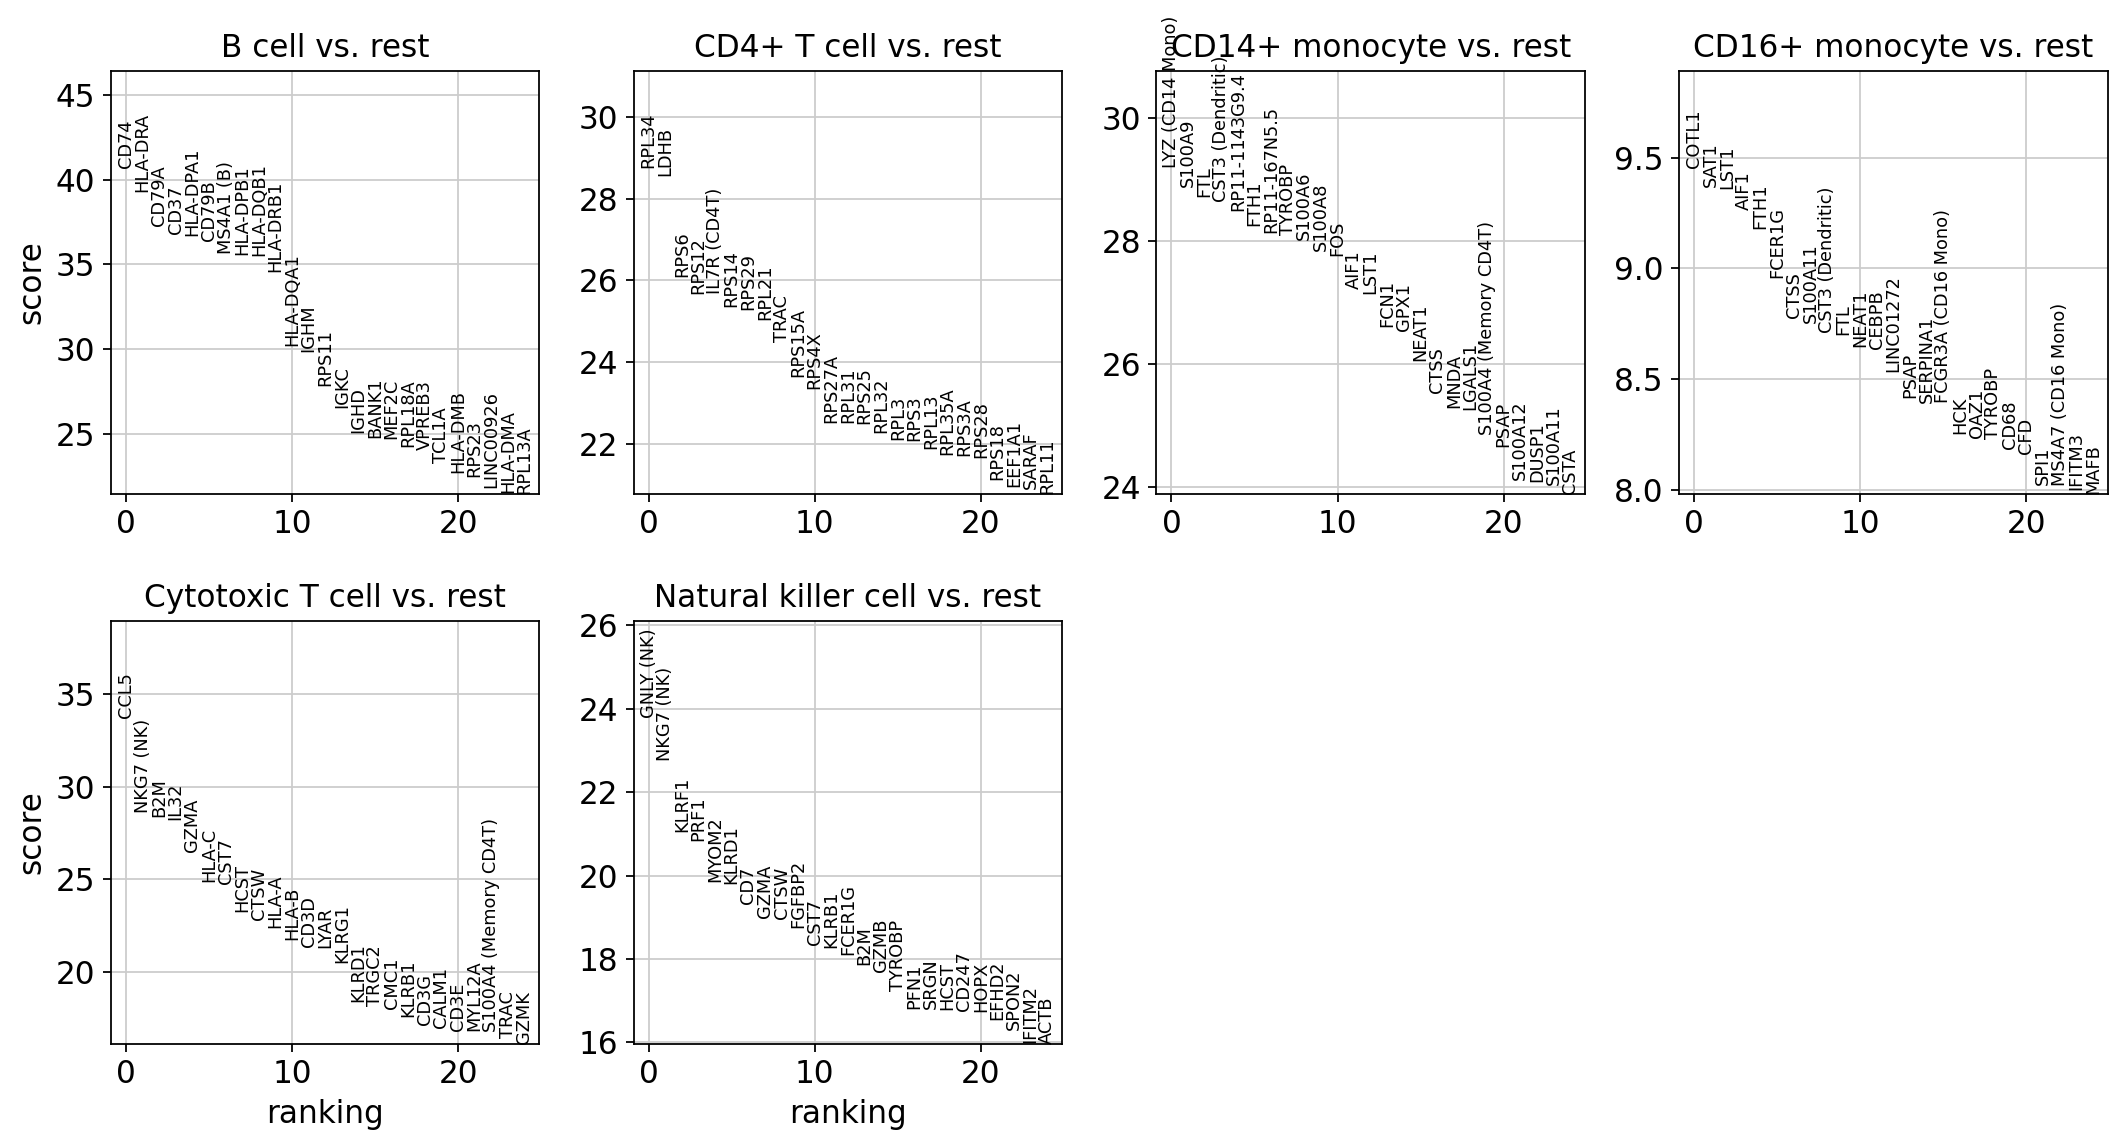

In [106]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'merged', method='wilcoxon') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)


In [101]:
# show top 10 genes per cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


0     1        2              3         4      5      6       7
0  RPL34  CCL5    TCL1A            LYZ   HLA-DRA   GNLY  COTL1  LILRA4
1   LDHB  NKG7     CD74         S100A9      CD74   NKG7   SAT1    IRF7
2   RPS6   B2M     IGHD            FTL     MS4A1  KLRF1   LST1    UGCG
3  RPS12  IL32    CD79B           CST3  HLA-DPA1   PRF1   AIF1    GZMB
4   IL7R  GZMA  HLA-DRA  RP11-1143G9.4     CD79A  MYOM2   FTH1    NPC2

In [102]:
# show p-values
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

0_n       0_l       1_n       1_l      2_n       2_l  \
0         RPL34  0.677538      CCL5  5.075506    TCL1A  7.691890   
1          LDHB  2.610741      NKG7  4.581691     CD74  3.592872   
2          RPS6  0.733556       B2M  0.849882     IGHD  6.013868   
3         RPS12  0.710260      IL32  3.157981    CD79B  4.345144   
4          IL7R  3.005739      GZMA  3.891090  HLA-DRA  4.119440   
...         ...       ...       ...       ...      ...       ...   
16850      CYBA -1.796950     RPS13 -0.556650   TMSB4X -0.721759   
16851   HLA-DRA -3.889058  HLA-DRB1 -2.710078   S100A6 -3.149128   
16852  HLA-DPB1 -3.752504      CD74 -1.864398     HCST -4.749836   
16853  HLA-DRB1 -4.318834     RPL11 -0.475087   S100A4 -4.503054   
16854      CD74 -2.696954   HLA-DRA -3.358439      B2M -0.958265   

                 3_n       3_l       4_n       4_l     5_n       5_l     6_n  \
0                LYZ  9.261611   HLA-DRA  3.782874    GNLY  7.299719   COTL1   
1             S100A9  8.675640      CD74  3.084636    NKG7  5.437871    SAT1   
2                FTL  3.595553     MS4A1  3.667219   KLRF1  6.298194    LST1   
3               CST3  6.882038  HLA-DPA1  3.072397    PRF1  4.577177    AIF1   
4      RP11-1143G9.4  7.456281     CD79A  3.546734   MYOM2  5.719012    FTH1   
...              ...       ...       ...       ...     ...       ...     ...   
16850         MALAT1 -0.985532      CD3D -5.375102  RPL18A -1.279415   RPLP2   
16851         RPL23A -1.167417    GIMAP7 -4.508081   RPL11 -1.272114    RPL3   
16852           RPS3 -1.389320      IL32 -4.547853   RPL32 -1.148836  RPL13A   
16853           RPL3 -1.420925      HCST -3.973558   RPL34 -1.190356   RPL13   
16854          RPS27 -1.198273    TMSB4X -0.834187   RPL39 -1.372834   RPS27   

            6_l     7_n       7_l  
0      4.296225  LILRA4  8.789766  
1      4.919384    IRF7  6.195355  
2      6.068448    UGCG  6.427690  
3      5.723843    GZMB  6.376854  
4      3.394590    NPC2  4.801705  
...         ...     ...       ...  
16850 -0.821340   TXNIP -2.118985  
16851 -1.191827  TMSB4X -0.838664  
16852 -0.820450   HLA-E -2.008624  
16853 -0.832114   HLA-C -1.633139  
16854 -0.893743    CD52 -3.066517  

[16855 rows x 16 columns]

In [103]:
result.keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

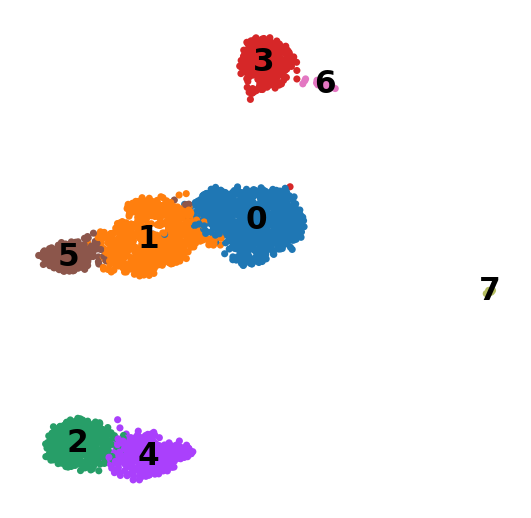

In [104]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf', )


In [105]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading
